In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# Append src directory to path
import sys
sys.path.append('C:\\Users\\kingt\\Dropbox\\Programming\\NeuralSimV3\\NeuroSimV3\\python\\src')

In [138]:
import numpy as np
import matplotlib.pyplot as plt

from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from neuron_templates import neuron_type_IZ
from network_grower import *
from network_generators import *
from neuron_type_distributor import *
from network_weight_distributor import *
from external_inputs import *

## Network

### Topology

In [139]:

two_node = False
three_node = False
ten_ring = False
watts_strogatz = False
geo_pref = True

if two_node:
    # Fully connected 2 neuron network
    G = nx.DiGraph()
    G.add_nodes_from([0, 1])
    # G.add_edges_from([(0, 1), (1, 0), (0, 0), (1, 1)])
    G.add_edges_from([(0, 1), (1, 0)])
elif three_node:
    # Fully connected 3 neuron network
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)])
    # G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (0, 0), (1, 1), (2, 2)])
elif ten_ring:
    # Directed ring of 10 neurons, connected to 2 nearest neighbors
    n = 20
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    G.add_edges_from([(i, (i + 1) % n) for i in range(n)])
    G.add_edges_from([(i, (i + 2) % n) for i in range(n)])
    G.add_edges_from([(i, (i - 1) % n) for i in range(n)])
    G.add_edges_from([(i, (i - 2) % n) for i in range(n)])
elif watts_strogatz:
    n = 20
    k = 4  # Each node is connected to k nearest neighbors in ring topology
    p = 0.1  # The probability of rewiring each edge
    G = nx.watts_strogatz_graph(n, k, p)
    G = G.to_directed()
elif geo_pref:
    G = spatial_pa_directed_var_out(n=50, box_dim=2, alpha=2.0, pa_gamma=1.0, local_frac=0.7,
                                kout_dist="lognormal", kout_params=(0.7, 0.9), kmin=1, seed=None)


    ensure_min_in_out(G)

    # Graph density
    print("Graph density:", nx.density(G))
    # Number of nodes and edges
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

# Small-worldedness of G
# print("Small-worldedness:", smallworld.omega(G.to_undirected(), niter=5, nrand=10))

Graph density: 0.06489795918367347
Number of nodes: 50
Number of edges: 159


In [140]:
# Small-worldedness of G
print("Small-worldedness:", smallworld.omega(G.to_undirected(), niter=2, nrand=4))

Small-worldedness: 0.19059787183655508


In [141]:
G.nodes(data=True)[0]

{'pos': (np.float64(0.6694084025609675), np.float64(0.7381357966697463))}

Text(0.5, 1.0, 'Fully Connected 2 Neuron Network')

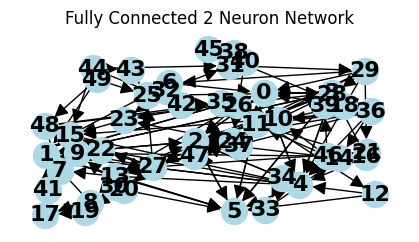

In [142]:
# Plot the network
# Position from "pos" node attribute from G, (x, y) coordinates in numpy array
pos = [np.array([G.nodes[i].get('pos')[0], G.nodes[i].get('pos')[1]]) for i in G.nodes()]
plt.figure(figsize=(4, 2))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=350, font_size=16, font_weight='bold', arrowsize=20)
plt.title("Fully Connected 2 Neuron Network")

### Assign types

In [143]:
# Assign all nodes to ntype ss4
# ntype = 'p23'

# for i in G.nodes:
#     G.nodes[i]['ntype'] = ntype
#     G.nodes[i]['inhibitory'] = False
#     G.nodes[i]['layer'] = 0

dist_result = assign_EI_and_subtypes_with_quotas(G, target_frac_exc=0.7, EXC_quota={"p23": 0.7, "TC": 0.3} , solver="greedy")

dist_result

{'EI_bias_used': 0.8472978603872034,
 'target_frac_exc': 0.7,
 'achieved_frac_exc': 0.76,
 'EXC_counts': {'p23': np.int64(27), 'TC': np.int64(11)},
 'INH_counts': {'TI': np.int64(3),
  'TRN': np.int64(2),
  'b': np.int64(2),
  'nb': np.int64(2),
  'nb1': np.int64(3)},
 'n_exc': 38,
 'n_inh': 12,
 'solver': 'greedy'}

### Weight assignment

In [144]:
G = assign_biological_weights(G, mu_E=-1.2, sigma_E=1.3,
                        mu_I=-0.8, sigma_I=0.6,
                        use_distance=True, lambda_mm=20.0, kernel="exp")

# G = assign_biological_weights(G)

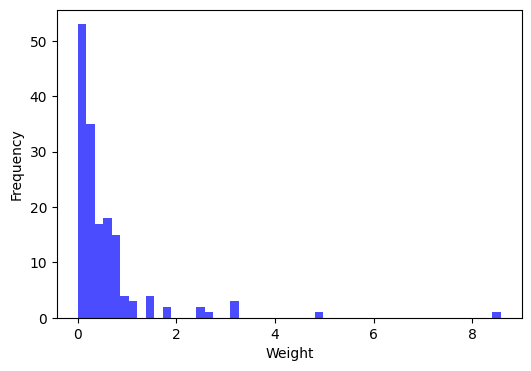

In [145]:
# Plot weight distribution
weights = [G.edges[i]['weight'] for i in G.edges]
plt.figure(figsize=(6, 4))
plt.hist(weights, bins=50, color='blue', alpha=0.7)
# plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

### Final tuning

In [146]:
# for i in G.edges:
#     u, v = i
#     # Euclidean distance between node pos
#     G.edges[i]['distance'] = np.linalg.norm(pos[u] - pos[v])

# Mean distance
mean_distance = np.mean([G.edges[i]['distance'] for i in G.edges])
distance_scale = 15.0


weight_scale_excitatory = 20.0
weight_scale_inhibitory = 20.0

for i in G.edges:
    u, v = i
    # G.edges[i]['weight'] = 11.0
    # Random distance around 1
    # G.edges[i]['distance'] = (1 + 0.3 * (2 * random.random() - 1)) * distance_scale
    # Normalized distance and multiply by distance scale
    G.edges[i]['distance'] = G.edges[i]['distance'] / mean_distance * distance_scale
    G.edges[i]['dendritic'] = False

    # Weight scaling
    if not G.nodes[u]['inhibitory']:
        G.edges[i]['weight'] *= weight_scale_excitatory
    else:
        G.edges[i]['weight'] *= weight_scale_inhibitory


In [147]:
# print(G.nodes(data=True))
# print(G.edges(data=True))

C:\Users\kingt\AppData\Local\Temp\ipykernel_13840\520809068.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


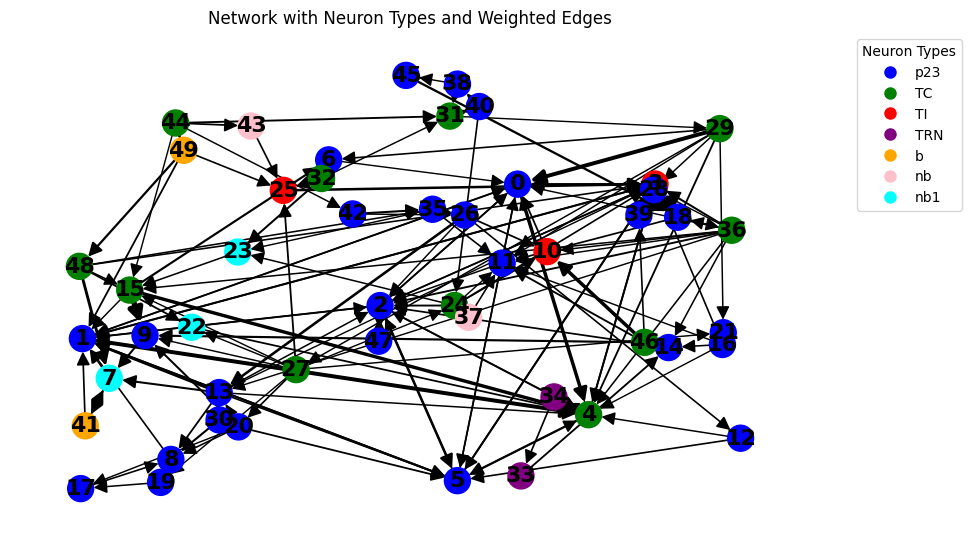

In [148]:
# Plot network with node color based on ntype
ntype_colors = {
    "p23": "blue",
    "TC": "green",
    "TI": "red",
    "TRN": "purple",
    "b": "orange",
    "nb": "pink",
    "nb1": "cyan"
}

# Extract node colors
node_colors = [ntype_colors.get(G.nodes[i]['ntype'], 'gray') for i in G.nodes]

# Extract edge weights (default to 1 if missing)
weights = [d.get('weight', 1.0) for _, _, d in G.edges(data=True)]

# Scale edge thickness for visibility (tweak the multiplier as needed)
min_w, max_w = min(weights), max(weights)
if max_w > min_w:
    edge_widths = [1 + 5 * ((w - min_w) / (max_w - min_w)) for w in weights]
else:
    edge_widths = [2 for _ in weights]  # fallback if all weights are identical

# Draw
plt.figure(figsize=(8, 5))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=350,
    font_size=16,
    font_weight='bold',
    arrowsize=20,
    width=edge_widths
)
plt.title("Network with Neuron Types and Weighted Edges")

# Legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               label=ntype, markerfacecolor=color, markersize=10)
    for ntype, color in ntype_colors.items()
]
plt.legend(handles=handles, title="Neuron Types",
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Simulation

In [149]:
dt = 0.1

In [150]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = ["p23", "TC", "TI", "TRN", "nb1", "b", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True, True, True, True, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [151]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

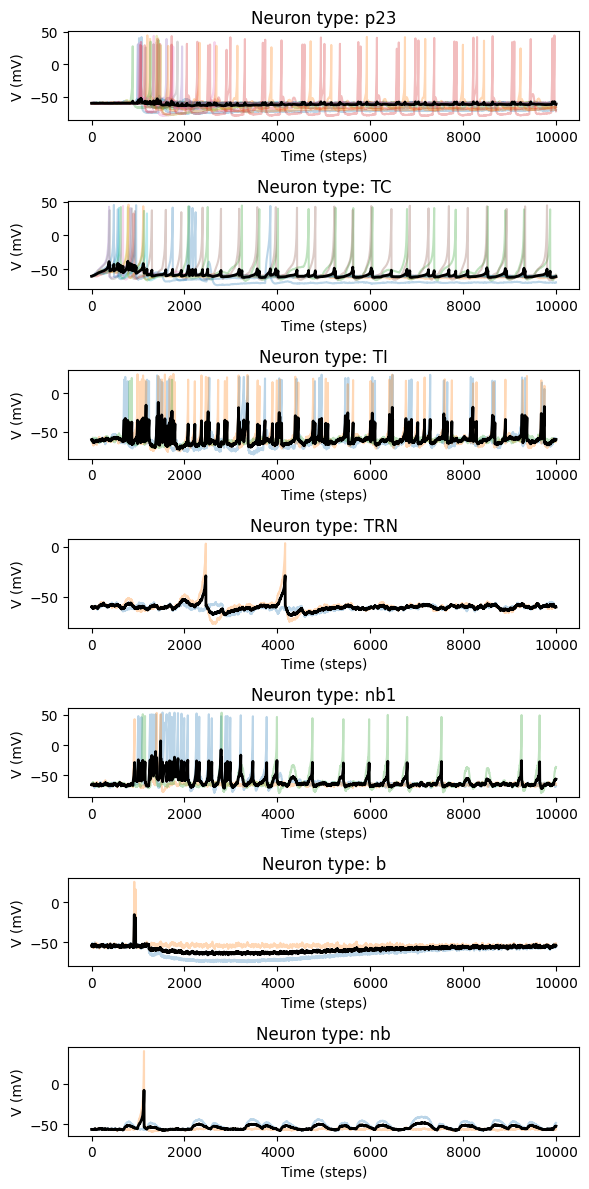

In [164]:
sim = Simulation(connectome, dt, stepper_type="adapt")

I_ext = np.zeros((pop.n_neurons))
I_ext[pop.get_neurons_from_type("TC")] = 150
# I_ext[pop.get_neurons_from_type("TI")] = 50

rate = np.zeros(n_neurons)
rate[pop.get_neurons_from_type("TC")] = 0.5
poisson = PoissonInput(n_neurons, rate, amplitude=1.0)


# I_ext = 100

for i in range(1000):
    sensory_spikes = poisson(0.1)
    sim.step(spike_ext=sensory_spikes)
    # sim.step(I_ext=I_ext)

I_ext[:] = 0

for i in range(9000):
    sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 12))

In [132]:
sim.stats.compute_metrics(dt)

C:\Users\kingt\Dropbox\Programming\NeuralSimV3\NeuroSimV3\python\src\overhead.py:124: RuntimeWarning: invalid value encountered in divide
  fanos = np.where(mu > 0, var / mu, np.nan)


{'rate_mean_Hz': 4.31956804319568,
 'rate_median_Hz': 0.9999000099990001,
 'rate_p95_Hz': 15.54844515548445,
 'ISI_CV_median': 1.168328027986412,
 'refractory_violations_per_neuron': 0.28,
 'Fano_median_300ms': 1.0000000000000002,
 'mean_noise_corr_50ms': 0.5918236507821416,
 'pop_spec_entropy': 7.974923828042793}

In [133]:
connectome.compute_metrics()

{'smallworld_omega': 0.13786233099800027,
 'spectral_radius': 59.92730449493723,
 'n_nodes': 50,
 'n_edges': 199,
 'n_E': 30,
 'n_I': 20,
 'k_in_mean': 3.98,
 'k_out_mean': 3.98,
 's_in_mean': 50.76835676634911,
 's_out_mean': 50.7683567663491,
 'k_in_std': 4.55125010859878,
 'k_out_std': 4.103209296466882,
 's_in_std': 62.76266346298137,
 's_out_std': 64.14741114715225,
 'edge_frac_EE': 0.5477386934673367,
 'edge_frac_EI': 0.271356783919598,
 'edge_frac_IE': 0.1457286432160804,
 'edge_frac_II': 0.035175879396984924,
 'reciprocity': 0.22110552763819097,
 'assort_out_to_in_degree': -0.136056068431734,
 'assort_outStrength_to_inStrength': -0.06884582905365356,
 'clustering_avg_weighted': 0.012657693747212382,
 'transitivity_unweighted': 0.37275204359673025,
 'rich_club_phi_k': 0.6666666666666666,
 'rich_club_k_sel': 16,
 'triadic_census': {'003': 12711,
  '012': 4810,
  '102': 700,
  '021D': 401,
  '021U': 286,
  '021C': 256,
  '111D': 167,
  '111U': 32,
  '030T': 128,
  '030C': 2,
  '20

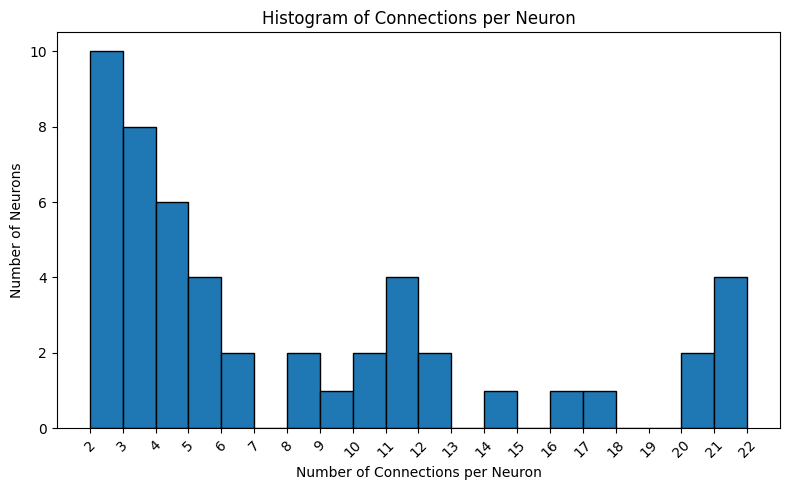

(array([10,  8,  6,  4,  2,  0,  2,  1,  2,  4,  2,  0,  1,  0,  1,  1,  0,
         0,  2,  4]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22.]))

In [134]:
connectome.plot_connections_histogram()

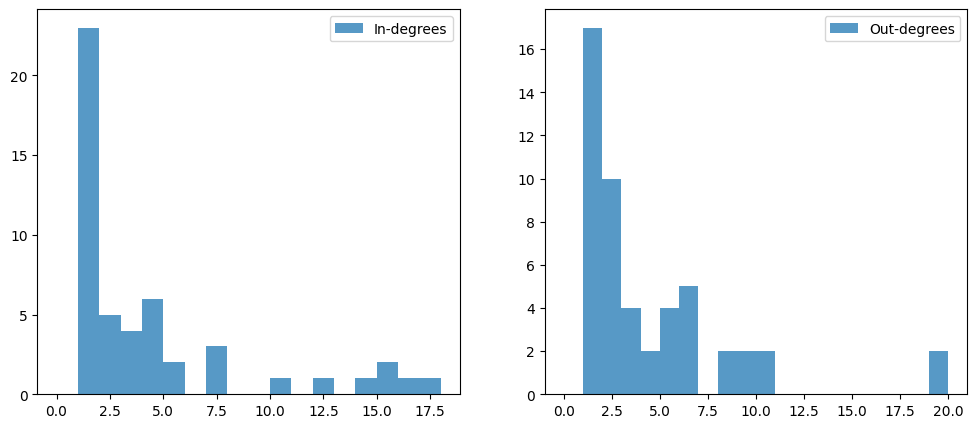

In [135]:
# Histogram of in-degrees and out-degrees
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(max(in_degrees) + 2), alpha=0.75, label='In-degrees')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(max(out_degrees) + 2), alpha=0.75, label='Out-degrees')
plt.legend(loc='upper right')